# Adaptive PDE discretizations on Cartesian grids
## Volume : Algorithmic tools
## Part : Generalized acuteness
## Chapter : Norms defined by a Hooke tensor

The propagation speed of seismic waves is governed by the elastic properties of the medium, encoded in a Hooke tensor $c$. The dependency is anisotropic, non-linear and rather complex from the algebraic point of view, involving for instance a polynomial constraint of degree six in three variables. In this notebook, we provide some detail on the definition and numerical computation of these quantities, implemented in the `Hooke` class of norms (`agd.Metrics.Seismic.Hooke`). We also extract some quantities of interest for the fast marching method used to solve the related eikonal equations.

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Geometric distorsion](#1.-Geometric-distorsion)
    * [1.1 Considered norms](#1.1-Considered-norms)
    * [1.2 Half sphere sampling](#1.2-Half-sphere-sampling)
    * [1.3 Length distorsion](#1.3-Length-distorsion)
    * [1.4 Angular distortion](#1.4-Angular-distortion)
  * [2. Convexity of the constraint](#2.-Convexity-of-the-constraint)
    * [2.1 Quasi-concavity](#2.1-Quasi-concavity)
    * [2.2 Convexity of $\exp(-\alpha f_c)$.](#2.2-Convexity-of-$\exp(-\alpha-f_c)$.)
  * [3. Computation of a frame of reference](#3.-Computation-of-a-frame-of-reference)
    * [3.1 Alternative projections](#3.1-Alternative-projections)
    * [3.2 Optimization routines](#3.2-Optimization-routines)
    * [3.3 Two dimensions](#3.3-Two-dimensions)
    * [3.4 Three dimensions](#3.4-Three-dimensions)
  * [4 GPU acceleration of the TTI projection](#4-GPU-acceleration-of-the-TTI-projection)
    * [4.1 Taking advantage of VTI rotational invariance](#4.1-Taking-advantage-of-VTI-rotational-invariance)
    * [4.2 Validation tests](#4.2-Validation-tests)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('SeismicNorm','Algo'))

In [2]:
from agd.Metrics.Seismic import Hooke,Thomsen,TTI
from agd.Metrics import Riemann
from agd import Sphere
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
from agd.Plotting import SetTitle3D

In [3]:
import numpy as np
import copy
from matplotlib import pyplot as plt

## 1. Geometric distorsion

Norms arising in seismology have a fairly complex expression, but eventually their anisotropy is rather mild in comparison with other applications.
We illustrate this point by computing the length distortion associated with several geologic materials, as well as their angular distortion. 

This allows to choose a discretization stencil for the eikonal equation, ensuring the causality property and the  applicability of the fast marching method.
Note that for other applications involving stronger anisotropies, more complex (data adaptive, anisotropic) strategies are used in the design of the discretization stencil, see [Stern-Brocot tree](SternBrocot.ipynb) and [Voronoi vectors](VoronoiVectors.ipynb).

The algebraic expression of a `Hooke` norm is not used in this section, or any of its properties, except for symmetry (which allows to consider only half of the unit sphere).

### 1.1 Considered norms

The various geologic materials yield different types of anisotropies. We select a few for illustration.
The level sets of the norm illustrate the distance that the seismic waves can reach in a given time, which depends on their direction of propagation.

In [4]:
# Two specific examples
norm2 = Hooke.mica[0].extract_xz().rotate_by(0.3) 
norm3 = Hooke.mica[0].rotate_by(0.8,axis=(1,2,3))

In [5]:
# Some more examples
norms2 = [
    ("riemann2",Riemann.from_diagonal([1,3**2]).rotate_by(0.7)),
    ("mica2",Hooke.mica[0].extract_xz().rotate_by(1.2)),
    ("stishovite2",Hooke.stishovite[0].extract_xz().rotate_by(-0.5)),
    ("mudshale2",Hooke.from_ThomsenElastic(
        Thomsen.ThomsenData["Mesaverde (4903) mudshale"])[0].extract_xz().rotate_by(-0.5)),
]
norms3 = [
    ("mica3",Hooke.mica[0].rotate_by(0.3,axis=(1,2,3))),
    ("stishovite3",Hooke.stishovite[0].rotate_by(0.8,axis=(1,1,1))),
]

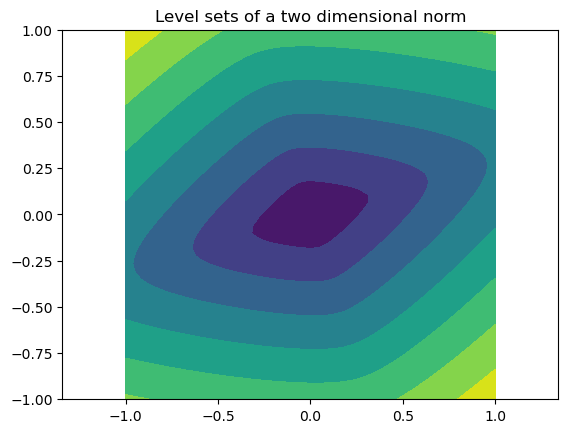

In [6]:
aX = np.linspace(-1,1)
X = np.meshgrid(aX,aX,indexing='ij')
plt.title("Level sets of a two dimensional norm"); plt.axis('equal');
plt.contourf(*X,norm2.norm(X)); 

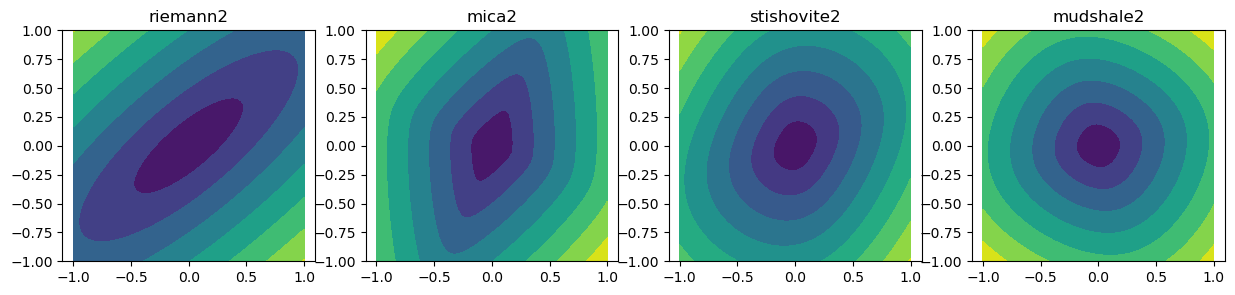

In [7]:
plt.figure(figsize=[15,3])
for i,(name,norm) in enumerate(norms2):
    plt.subplot(1,len(norms2),1+i)
    plt.title(name); plt.axis('equal')
    plt.contourf(*X,norm.norm(X))

### 1.2 Half sphere sampling

We sample our norms on the Euclidean unit sphere, so as to quantify their length distortion and other distortion.
Since the norms considered in this notebook are symmetric w.r.t the origin, it is enough to sample the half sphere.

We use $40$ points for the two dimensional half-sphere, and $40^2$ points for the three dimensional one. This sampling is dense enough to extract the desired numerical information.

In [8]:
def HalfSphereSampling(vdim,dens=40):
    """
    Produces a rather uniform sampling of the upper half of the unit sphere.
    - vdim (in [2,3]) : dimension of the sphere
    - dens : sampling density. dens**(vdim-1) points are returned.
    """
    if vdim==2: 
        θs = np.linspace(0,np.pi,dens,endpoint=False)
        return np.array([np.cos(θs),np.sin(θs)])
    elif vdim==3:
        θs = np.linspace(0,np.pi/2,dens//2)
        ϕs = np.linspace(0,2*np.pi,2*dens,endpoint=False)
        return np.array([(np.cos(θ)*np.cos(ϕ), np.cos(θ)*np.sin(ϕ), np.sin(θ)) for θ in θs for ϕ in ϕs]).T
    else: 
        raise ValueError("Unsupported dimension")

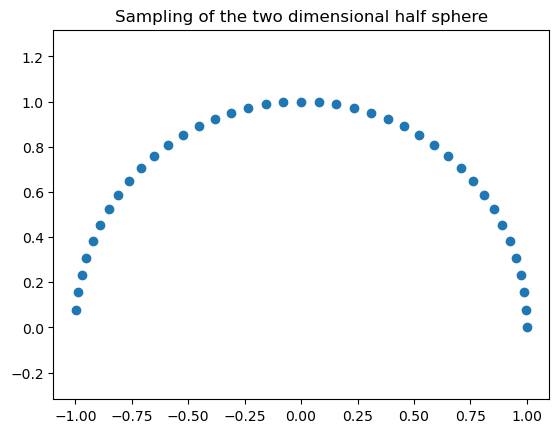

In [9]:
plt.title("Sampling of the two dimensional half sphere")
plt.scatter(*HalfSphereSampling(2));plt.axis('equal');

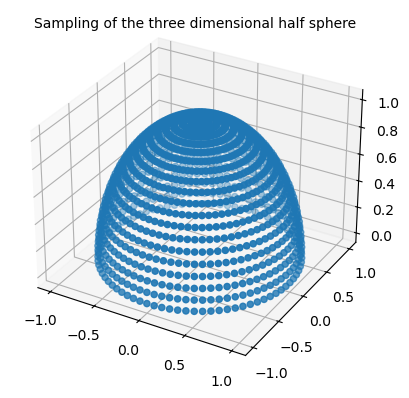

In [10]:
ax = plt.axes(projection='3d')
SetTitle3D(ax,"Sampling of the three dimensional half sphere")
ax.scatter(*HalfSphereSampling(3));

### 1.3 Length distorsion

A natural measure of the anisotropy associated with a norm is its maximal length distortion
$$
    \mu(N) := \max_{|u|=|v|=1} \frac {N(u)}{N(v)}.
$$
This quantity is to the ratio of the largest propagation speed, divided by the smallest propagation speed, over all space orientations.

In [11]:
def LengthDistortion(norm,**kwargs):
    p = HalfSphereSampling(norm.vdim,**kwargs)
    Np = norm.norm(p)
    return np.max(Np)/np.min(Np)

The mica medium has a length distortion of approximately $1.8$, which is large for a geological material (that is because mica is a crystal). Note that, with other types of norms, the HFM library routinely handles norms with length distortion exceeding $10$.

In [12]:
LengthDistortion(norm2)

1.826531520777687

By construction, length distortion is invariant under rotation of the norm. The (very small) difference arises because we use a finite sampling of the sphere.

In [13]:
LengthDistortion(norm2.rotate_by(np.pi/3))

1.827030499135136

Because mica is transversally isotropic, the length distortion of the three dimensional mica norm is equivalent.

In [14]:
LengthDistortion(norm3)

1.8283196290043453

For Riemannian norms, the length distortion can be computed in closed form, and is provided as the `anisotropy` member function. (In contrast, there is no simple closed form expression for the anisotropy of `Hooke` norms to our knowledge, and the `anisotropy` method is thus not implemented.) 

In [15]:
name,norm = norms2[0]
print(f"Norm : {name}. Length distortion : approximate {LengthDistortion(norm)}, exact {norm.anisotropy()}")

Norm : riemann2. Length distortion : approximate 2.999373021225438, exact 2.9999999999999996


In [16]:
for name,norm in norms2+norms3:
    print(f"Norm {name}. Length distortion {LengthDistortion(norm)}")

Norm riemann2. Length distortion 2.999373021225438
Norm mica2. Length distortion 1.8240126561699312
Norm stishovite2. Length distortion 1.3083676315734571
Norm mudshale2. Length distortion 1.0697929978210605
Norm mica3. Length distortion 1.8282899187030752
Norm stishovite3. Length distortion 1.3084655222014128


### 1.4 Angular distortion

The Fast-Marching method relies on a *causality property*, ensuring that the front arrival time at a given point can be computed in terms of neighbors earlier reached, and thus that the non-linear system of equations discretizing the PDE can be solved in a single pass.

For `Hooke` norms, we rely on a semi-lagrangian discretization of the eikonal equation, based on fixed stencils (illustrated below). In this context, the *causality property* follows from a geometrical *acuteness property*, as already observed by Sethian et al. The acuteness property requires that 
$$
    \Theta(N) + \Theta(V) < \pi/2,
$$
where $N$ is the norm, and $V$ is the stencil used for the PDE discretization.
We denoted:
* $\Theta(N)$ the angular distortion of the norm, defined as the largest (unoriented) angle between $p$ and $\nabla N(p)$, for each non-zero vector $p$. (By homogeneity, it suffices to consider the unit sphere, and by symmetry the half unit sphere.)
* $\Theta(V)$ the angular width of the stencil, defined as the largest (unoriented) angle between two vertices of a facet of the stencil.

Some standard stencils are illustrate below, whose angular width $\Theta(V)$ is easily computed:

Stencil | Dimension | Angular width $\Theta(V)$
--- | --- | ---
Square | 2 | $\pi/4$
Cut-cube | 3 | $\pi/3$
Cube | 3 | $0.955..$
Spiky-cube | 3 | $\pi/4$

(The exact angular width of the cube stencil is $\arccos(1/\sqrt 3)$.)

**In practice, for `Hooke` norms.** Most geologic materials are only midly anisotropic, so that the square stencil can be used in two dimensions, and the cut-cube in three dimensions. This is not true however of crystals, such as mica which exhibits stronger anisotropy and require more the refined spiky-cube stencil in three dimensions. 

**In practice, for strongly anisotropic norms arising in other applications.** The use of fixed stencils is inadequate when the anisotropy is strong, and one must instead produce adaptive and anisotropic stencils, using mathematical tools such as the [Stern-Brocot tree](SternBrocot.ipynb) and [Voronoi vectors](VoronoiVectors.ipynb).

![](Illustrations/SeismicNorm/FixedStencils.png)

The angular distortion of a norm is numerically evaluated by the next function.

In [17]:
def AngularDistortion(norm,**kwargs):
    p = HalfSphereSampling(norm.vdim,**kwargs)
    dNp = norm.gradient(p)
    ratio = lp.dot_VV(p,dNp)/np.linalg.norm(dNp,ord=2,axis=0)
    return np.arccos(np.min(ratio))

The angular distortion of the mica medium is less than $\pi/4$, which allows using the square stencil (in two dimensions), and the spiky cube stencil (in three dimensions).

In [18]:
μ = AngularDistortion(norm2)
print(f"Angular distortion of mica : {μ}, pi/4 : {np.pi/4}")

Angular distortion of mica : 0.7509887694791147, pi/4 : 0.7853981633974483


Note that angular distortion is invariant under rotation (up to numerical accuracy due to the finite sampling of the sphere).

In [19]:
AngularDistortion(norm2.rotate_by(1.2))

0.7497254150260353

Since the mica medium is transversally isotropic, the angular distortion of the three dimensional medium is identical (again up to numerical accuracy).

In [20]:
AngularDistortion(norm3)

0.7528581192017458

Angular distortion is bounded in terms of the Length distortion : one has 
$$
\mu(N) \cos \Theta(N) \geq 1.
$$

In [21]:
LengthDistortion(norm2) * np.cos(AngularDistortion(norm2))

1.3352210770062627

In the case of Riemannian metrics, the angular distortion has a closed form expression, as does the length distortion, and they are related by $(\mu(N)+\mu(N)^{-1})\cos \Theta(N) = 2$. Let us check this expression numerically.

In [22]:
name,norm = norms2[0]
μ = norm.anisotropy()
Θ = AngularDistortion(norm)
print(f"Norm {name}. Angular distortion : approximate {Θ}, exact {np.arccos(2/(μ+1/μ))} ")

Norm riemann2. Angular distortion : approximate 0.9272937826526069, exact 0.9272952180016121 


In [23]:
for name,norm in norms2+norms3:
    print(f"Norm {name}. Angular distortion {AngularDistortion(norm)}")

Norm riemann2. Angular distortion 0.9272937826526069
Norm mica2. Angular distortion 0.7521110091600802
Norm stishovite2. Angular distortion 0.3126982198178143
Norm mudshale2. Angular distortion 0.12435235682165878


Norm mica3. Angular distortion 0.752859677386624


Norm stishovite3. Angular distortion 0.34104154422640154


The upper bound on the angular width $\Theta(N)$ for the applicability of the fast-marching method with the cut-cube stencil, in three dimensions, is 
$\pi/2 - \Theta(\text{cut-cube}) = \pi/6$. As mentioned above, it is satisfied for all common geological materials, except crystals (such as mica).

In [24]:
np.pi/6

0.5235987755982988

## 2. Convexity of the constraint

In this section, we discuss in more detail the computational aspects of `Hooke` norms. 
For that purpose, let us fix a Hooke tensor $c$ of components $c_{ijkl}$ where $i,j,k,l \in \{1,\cdots,d\}$.


**Definition of the `Hooke` norm.**
For each vector $v \in R^d$ define a $d \times d$ symmetric matrix $m(v)$ of components 
$$
    m_c(v)_{ik} = \sum_{j,l} c_{ijkl} v_j v_l.
$$
In view of energetic considerations, one assumes that the Hooke tensor $c$ is positive (in an appropriate sense), which implies that $m(v)$ is a positive semi-definite matrix for each $v \in R^d$.

The *dual norm* to a `Hooke` norm is defined as the square root of the largest eigenvalue of the matrix $m_c(v)$
$$
    N_c^*(v) := \sqrt{\lambda_{\max}(m_c(v))},
$$
whereas the primal norm is defined dually, for all $w \in R^d$
$$
    N_c(w) := \max \{<w,v>;\ N_c^*(w) \leq 1\}.
$$
One can prove that $N_c^*$ is a norm, and in particular it is convex, so that $N_c$ is defined as the maximization of a linear objective function subject to a convex constraint.

**Efficient numerical computation.**
Despite being well posed, the above definition of $N_c$ is not very tractable numerically, due to the complex and costly evaluation of $N_c^*$.
Instead, let us define 
$$
    f_c(v) := \det(I - m_c(v)),
$$
so that the (closed) dual unit ball $B_c^*$ admits the equivalent characterizations
$$
B_c^* 
:= 
\{v; N_c^*(v) \leq 1\}
=
\text{CC}_0(\{f_c(v) \geq 0\}),
$$
where $\text{CC}_x(X)$ denotes the connected component of the point $x$ in the set $X$. We can thus rephrase the definition of $N_c$, with a slight abuse of notation, as 
$$
    N_c(w) := \{<w,v>;\ f_c(v) \geq 0,\ v \in \text{CC}_0\}.
$$
We have replaced the highly non-linear constraint $N^*_c(v)\leq 1$ with the polynomial constraint $f_c(v) \geq 0$, which is much more tractable numerically (in particular it is easy to differentiate). Note that $f_c$ is an in-homogeneous polynomial of degree $2d$ in $d$ variables, where $f\in \{2,3\}$ is the dimension.

**Convexity.** 
The dual norm $N_c^*$ is convex, as mentioned above, but properties of $f_c$ are slightly more subtle. 
One can show that:
* $f_c$ is quasi-concave on a neighborhood of $B_c^*$. (In other words the set $\{v \in B_c^*; f_c\geq \lambda\}$ is convex for all $\lambda$.)
* $f_c^{\frac 1 d}$ is strongly concave on $B_c^*$. Note that this function in not defined outside $B_c^*$.
* $\exp(-\alpha f_c)$ is strongly convex on a neighborhood of $B_c^*$, for sufficiently large $\alpha$.

The constraint function $f_c$ is a hidden method of the dual norm, evidenced below.

In [25]:
def F(norm,v): return -norm._dual_level(v) # Constraint function f_c

### 2.1 Quasi-concavity

The dual unit ball $B_c^*$ is the connected component of the origin delimited by the level set $f_c=0$, shown red.
As announced, the level sets of $\{f_c\geq \lambda\}$ within this region are convex, reflecting the quasi-concavity.

In [26]:
aX = np.linspace(-0.3,0.3)
X = np.array(np.meshgrid(aX,aX,indexing='ij'))
X_ad = ad.Dense2.identity(constant=X,shape_free=(2,))

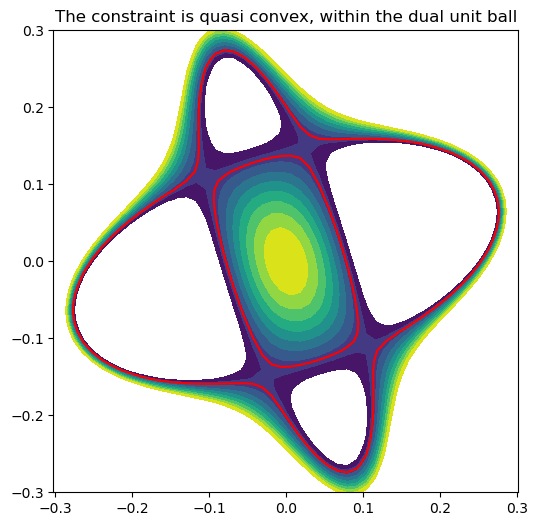

In [27]:
plt.figure(figsize=(6,6)); plt.axis('equal');
plt.title("The constraint is quasi convex, within the dual unit ball")
f = F(norm2,X)
plt.contourf(*X,f,np.linspace(-0.2,1,10))
plt.contour(*X,f,[0],colors='red');

The function $f_c$ however is *not* concave in $B_c^*$. Indeed, as illustrated below, the determinant of the hessian of $f_c$ changes sign in this region. 

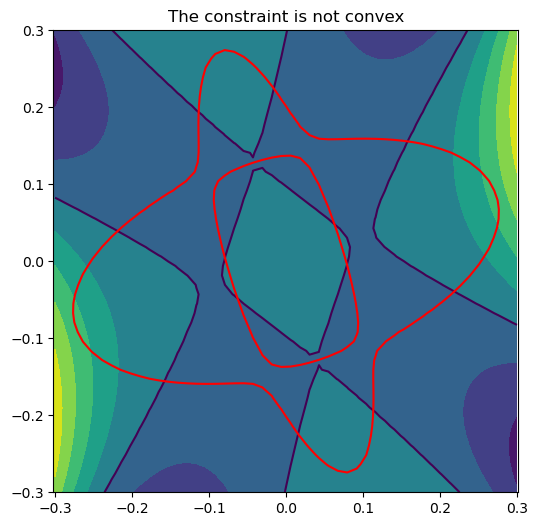

In [28]:
plt.figure(figsize=(6,6)); plt.axis('equal');
plt.title("The constraint is not convex")
f_ad = F(norm2,X_ad)
f = f_ad.value
det_h = lp.det(f_ad.hessian())
plt.contourf(*X,det_h)
plt.contour(*X,det_h,[0])
plt.contour(*X,f,[0],colors='red');

The function $f_c^{\frac 1 d}$ is strongly concave in $B_c^*$, and indeed its hessian is negative definite in the interior of this region. However $f_c^{\frac 1 d}$ is not very nice to use numerically due to the singularity on the boundary of $B_c^*$. 

/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Base.py:45: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Dense2.py:98: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


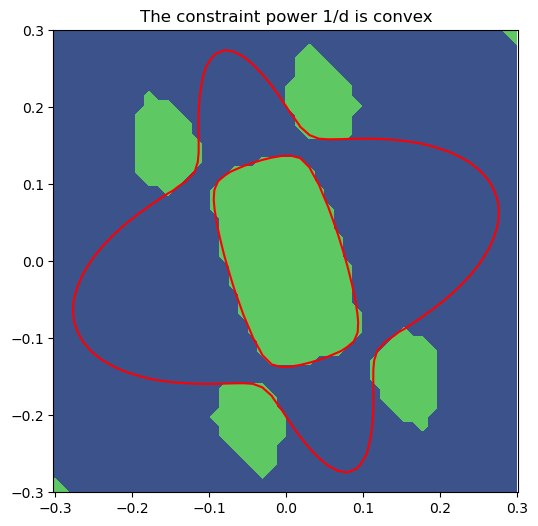

In [29]:
plt.figure(figsize=(6,6)); plt.axis('equal');
plt.title("The constraint power 1/d is convex")
f_pow_ad = np.maximum(0,F(norm2,X_ad))**(1/norm.vdim)
det_h_pow = lp.det(f_pow_ad.hessian())
plt.contourf(*X,det_h_pow>0)
plt.contour(*X,f_ad.value,[0],colors='red');

### 2.2 Convexity of $\exp(-\alpha f_c)$.

The function $\exp(-\alpha f_c)$ is known to be strongly convex on a neighborhood $B_c^*$, for sufficiently large $\alpha$, but the theoretical analysis is not quantitative. 
The next function estimates numerically the lower bound on the values of $\alpha$ which achieve this property.

Note that the strong convexity of a smooth function $\exp(-\alpha f)$ is equivalent to the pointwise positive definiteness property
$$
    \alpha \nabla f \nabla f^T - \nabla^2 f \succ 0.
$$

In [30]:
def LowerAlpha(norm,**kwargs):
    # Evaluate the dual norm on the Euclidean sphere
    p = HalfSphereSampling(norm.vdim,**kwargs)
    norm_pp = norm.contract(p)
    dual_norm = np.sqrt(np.linalg.norm(norm_pp,ord=2,axis=(0,1)))
    
    # Produce a sampling of the dual unit sphere, evaluate the constraint and derivatives
    q = p/dual_norm 
    q_ad = ad.Dense2.identity(constant=q,shape_free=(norm.vdim,))
    dual_level_ad = norm._dual_level(q_ad)
    assert np.allclose(dual_level_ad.value,0) 
    
    # Compute the minimal relaxation parameter
    h = dual_level_ad.hessian()
    g = dual_level_ad.gradient()
    λ = ad.Dense.identity(constant=1.)
    det_ad = lp.det(h + λ * lp.outer_self(g)) # Polynomial of degree one w.r.t λ
    α = -det_ad.value/det_ad.coef
    
    return np.max(α)

In practice, the exponential $\exp(-\alpha f_c)$ takes rather extreme values, which makes this quantity unfriendly from the numerical point of view due to the risk of overflow.

In [31]:
α = LowerAlpha(norm2)
α

10.129535935595026

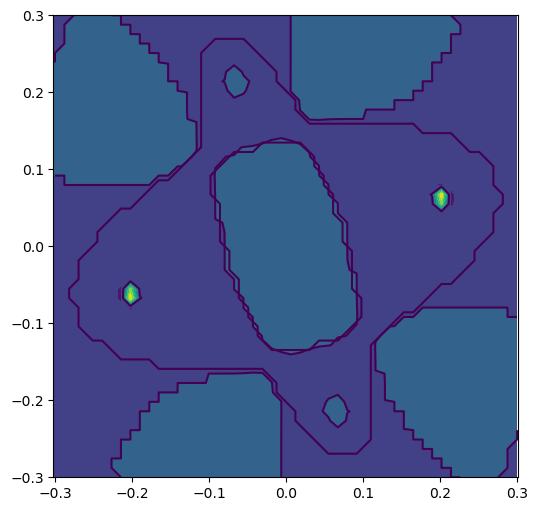

In [32]:
plt.figure(figsize=(6,6));plt.axis('equal');
exp_ad = np.exp(-α*F(norm2,X_ad))
value = exp_ad.value
det_h = lp.det(exp_ad.hessian())
plt.contourf(*X,det_h)
plt.contour(*X,det_h,[0])
plt.contour(*X,value<=1);

As already mentioned, the hessian of $\exp(-\alpha f_c)$ is proportional to 
$$
    \alpha \nabla f_c \nabla f_c^T -\nabla^2 f_c.
$$
We check in the following illustration that it is positive definite in the interior of $B_c^*$ with the value $\alpha$ produced by the `LowerAlpha` function. In addition, this hessian degenerates on the boundary of $B_c^*$, showing that $\alpha$ is indeed the lower bound.

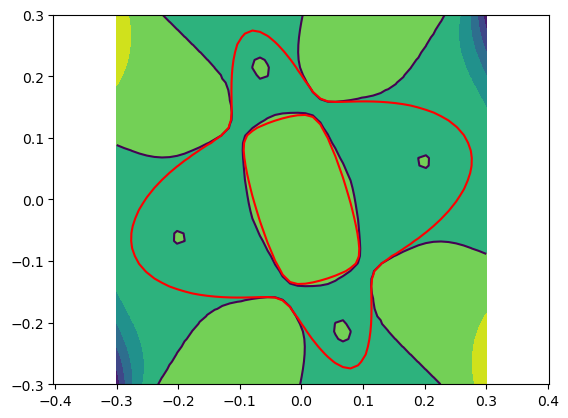

In [33]:
plt.axis('equal')
f_ad = F(norm2,X_ad)
v = f_ad.value
g = f_ad.gradient()
h = f_ad.hessian()
det_h = lp.det(α*lp.outer_self(g)-h)
plt.contourf(*X,det_h)
plt.contour(*X,det_h,[0])
plt.contour(*X,v,[0],colors='red');

In [34]:
for name,norm in norms2[1:]+norms3:
    print(f"Norm {name}. Lower bound on α {LowerAlpha(norm)}")

Norm mica2. Lower bound on α 10.131242536881315
Norm stishovite2. Lower bound on α 3.496438839401178
Norm mudshale2. Lower bound on α -0.05585949317270378
Norm mica3. Lower bound on α 39.549249651079755
Norm stishovite3. Lower bound on α 61.2186314407292


If a parameter $\alpha$ has been determined (as above) such that $\alpha \nabla f_c \nabla f_c^T -\nabla^2 f_c \succ 0$, then it can be taken into account in the  Sequential Quadratically Constrained Programming (SQCP) routine used to compute the norm. This ensures that all inverted matrices are positive definite, and is in principle safer. Note that SQCP is an iterative method for solving problems of the form
$$
    \max \{<w,v>; f(v) \leq 0\},
$$
which is based on successively approximating $f$ with its second order Taylor expansion (indeed the exact solution of this problem is known in closed form when the constraint is quadratic).

In numerical experiments, somewhat surprisingly, the SQCP method is rather insensitive to the parameter $\alpha$, even when values are used that do not enforce the positive definiteness of $-\nabla^2 f_c$ on $B_c^*$. In practice leaving this parameter to the default value $\alpha=0$ appears to be fine. 

In [35]:
def check_qconv(norm,α,**kwargs):
    norm_ = copy.copy(norm)
    norm_.qconv_sqp = α # Parameter such that α grad(f_c) grad (f_c)^T - hess(f_c) > 0
    norm_.niter_sqp = 12 # A few more iterations than default
    p = HalfSphereSampling(norm.vdim,**kwargs)
    return np.max(np.abs(norm.norm(p)-norm_.norm(p))) # Largest absolute error on unit ball

In [36]:
print("Lower bound of α ensuring strong convexity : ", LowerAlpha(norm2))
# Norm is correctly computed in both cases, with identical value
assert check_qconv(norm2,60.)<1e-12

Lower bound of α ensuring strong convexity :  10.129535935595026


In [37]:
print("Lower bound of α ensuring strong convexity : ", LowerAlpha(norm3))
assert check_qconv(norm3,60.) <1e-12 

Lower bound of α ensuring strong convexity :  39.54959545329993


In [38]:
for name,norm in norms2[1:]+norms3:
    print(f"Norm {name}, effect of $α$ {check_qconv(norm,60.)}")

Norm mica2, effect of $α$ 5.551115123125783e-17
Norm stishovite2, effect of $α$ 2.0816681711721685e-17
Norm mudshale2, effect of $α$ 1.6263032587282567e-19


Norm mica3, effect of $α$ 5.551115123125783e-17


Norm stishovite3, effect of $α$ 1.5265566588595902e-15


## 3. Computation of a frame of reference

Most materials arising in geology which are *anisotropic* inherit this property from a *layered structure*, which can have various and independent origins:
* (Atom scale) In a crystal, due to the periodic arrangement of atoms.
* (Centimeter scale) Successive deposits on the sea floor, whose constitutents may vary periodically.
* (Kilometer scale) Fault interfaces produce anisotropic elastic response along them.

If a frame of reference aligned with the layers is used, then the Hooke tensor typically takes a block-diagonal structure. Depending on the some shared coefficient values, the material symmetry is known as *hexagonal*, *tetragonal*, or *orthorombic*.

In [39]:
print("Mica in a frame of reference :\n", Hooke.mica[0].hooke)
print("\nMudshale in a frame of reference :\n",Hooke.from_ThomsenElastic(
    Thomsen.ThomsenData["Mesaverde (4903) mudshale"])[0].hooke.round())

Mica in a frame of reference :
 [[178.   42.4  14.5   0.    0.    0. ]
 [ 42.4 178.   14.5   0.    0.    0. ]
 [ 14.5  14.5  54.9   0.    0.    0. ]
 [  0.    0.    0.   12.2   0.    0. ]
 [  0.    0.    0.    0.   12.2   0. ]
 [  0.    0.    0.    0.    0.   67.8]]

Mudshale in a frame of reference :
 [[21906646.  5949886. 11051999.        0.        0.        0.]
 [ 5949886. 21906646. 11051999.        0.        0.        0.]
 [11051999. 11051999. 20511841.        0.        0.        0.]
 [       0.        0.        0.  7306209.        0.        0.]
 [       0.        0.        0.        0.  7306209.        0.]
 [       0.        0.        0.        0.        0.  7978380.]]


In dimension $d=2$, the reference structure of interest is built of a $2\times 2$ block, and an additional diagonal coefficient.

In [40]:
Hooke.mica[0].extract_xz().hooke

array([[178. ,  14.5,   0. ],
       [ 14.5,  54.9,   0. ],
       [  0. ,   0. ,  12.2]])

When a rotation is applied to the medium, this block structure lost, is obviously.

In [41]:
norm3.hooke.round(1)

array([[128.3,  36.8,  39.4,  -0.2, -43.1,   3. ],
       [ 36.8, 176.9,  20.6,   7.6, -10.9,   3.8],
       [ 39.4,  20.6,  54.9,   0.9,  -6.3,  -2.6],
       [ -0.2,   7.6,   0.9,  23.9,  -1.9, -22. ],
       [-43.1, -10.9,  -6.3,  -1.9,  37.2,   1.3],
       [  3. ,   3.8,  -2.6, -22. ,   1.3,  56.5]])

The `Hooke` class can handle general elliptic Hooke tensors, hence the frame of reference has no particular interest to it. However there are other numerical methods, such as the `TTI` (Tilted Transversally Isotropic) class of geological materials in the `agd` library, which require it. The frame of reference is often not available in the input data, if for instance it arises from the homogeneization of a complex material, and therefore it must be approximated or computed. 

Inspired by works of Paul Cupillard, we propose to approximate a frame of reference using numerical optimization. 

In [42]:
def proj_orthorombic(c):
    """Project onto the vector space of Hooke tensors corresponding to orthorombic materials in their frame of reference"""
    to_orthorombic = (c[0,0],c[0,1],c[0,2],c[1,1],c[1,2],c[2,2],c[3,3],c[4,4],c[5,5]) # Seismologists start at 1 ...
    return Hooke.from_orthorombic(*to_orthorombic).hooke

def frame_score(c,proj,r):
    """Score for wether c coincides with its projection in the frame defined by r"""
    c = c.rotate(lp.transpose(r)) # Put in specified frame
    c.hooke -= proj(c.hooke) # Substract projection 
    return (c.to_Mandel()**2).sum(axis=(0,1)) # Return frobenius norm squared

By construction, the score vanishes if the correct frame is produced, and is positive otherwise.

In [43]:
r = lp.rotation(np.pi/3,axis=(1,2,3))
norm = Hooke.mica[0].rotate(r)
print("Vanishing score in the correct frame : ",frame_score(norm,proj_orthorombic,r))
print("Positive score otherwise : ",frame_score(norm,proj_orthorombic,np.eye(3)))      

Vanishing score in the correct frame :  9.442701583533177e-27
Positive score otherwise :  14066.444179546052


The reference frame reconstruction problem for a Hooke tensor thus be rephrased as 
$$
    min_{r \in SO_d} f(r),
$$
where $f(r) = $`frame_score(norm,proj_orthorombic,r)`. Alternatively, projections onto the hexagonal and tetragonal symmetries may be used as well.

One may parametrize direct rotations from a sphere
* by their first column, which belongs to $S^1$, in dimension two. (This is a bijection.)
* by the corresponding unit quaternion, which belongs to $S^3$, in dimension three. (This is a double cover.)

Using this quadratic parametrization $R : S^n \to SO_d$, we obtain a sphere constrained optimization problem, in four variables in dimension three (resp. two variables in dimension two). The objective function is a polynomial of degree $2 \times 4 \times 2 = 16$. There exists global methods for such problems, based on positive definite relaxations, but we shall not use them here now.
Instead, we content ourselves with a combination of exhaustive search and Newton optimization. The sphere itself is parametrized by the equatorial projection.

### 3.1 Alternative projections

In addition to the three dimensional orthorombic materials, the hexagonal and tetragonal symmetries are also of interest, as well as the (2,1) block diagonal structure in two dimensions. Projections on these spaces of matrices are needed to optimize the corresponding frame.
We use orthogonal projections in the Frobenius scalar product associated with the Mandel form of the Hooke tensor.

In [44]:
def proj_hooke2(c):
    """Project onto the vector space of Hooke tensors with (2,1) block diagonal structure"""
    z = np.zeros_like(c[0,0])
    return ad.array([
        [c[0,0],c[0,1],     z],
        [c[1,0],c[1,1],     z],
        [     z,     z,c[2,2]] ])

In [45]:
def proj_tetragonal(c):
    """Tetragonal Hooke tensors share the coefficients c11=c22, c13=c23, c44=c55"""
    c11,c12,c13,c22,c23,c33,c44,c55,c66 = ( # Seismologists start at 1 ...
        c[0,0],c[0,1],c[0,2],c[1,1],c[1,2],c[2,2],c[3,3],c[4,4],c[5,5])
    α=(c11+c22)/2
    γ=(c13+c23)/2
    δ=(c44+c55)/2
    return Hooke.from_orthorombic(α,c12,γ,α,γ,c33,δ,δ,c66).hooke

In [46]:
def proj_hexagonal(c):
    """Hexagonal Hooke tensors are tetragonal, with the additional property that c66=(c11-c12)/2"""
    c11,c12,c13,c22,c23,c33,c44,c55,c66 = ( # Seismologists start at 1 ...
        c[0,0],c[0,1],c[0,2],c[1,1],c[1,2],c[2,2],c[3,3],c[4,4],c[5,5])
    α=(3*(c11+c22)+2*c12+4*c66)/8
    β=(c11+c22+6*c12-4*c66)/8
    γ=(c13+c23)/2
    δ=(c44+c55)/2
    return Hooke.from_orthorombic(α,β,γ,α,γ,c33,δ,δ,(α-β)/2).hooke

### 3.2 Optimization routines

We parametrize rotations from the unit ball, via quaternions in dimension three, and the simple angular parametrization in dimension two.
A roughly uniform sampling of the unit ball is produced by an adequate function.

The frame score is extremized via a Newton method, in a purely naive manner : no adaptive stepping is used, and no check of the positive definiteness of the Hessian. We look for a *minimum* of the frame score, but the method is blind to this, and it actually converges a local *maximum* in a large proportion of cases. Nevertheless, if one uses enough seeds, one of them is in practice usually caught in the attraction basin of the optimal frame, which is found by the Newton method, and is eventually selected and returned.

<!---
# Attempt to eliminate matrices with excessive condition number. Not very convincing.
def newton_extremize(f,x,niter,max_cond=1e20):
    """
    Runs niter steps of Newton's method for extremizing f. 
    (A.k.a, solve grad(f) = 0)
    """
    x_ad = ad.Dense2.identity(constant=x,shape_free=(len(x),))
    for i in range(niter):
        f_ad = f(x_ad)
        H = f_ad.hessian(); 
        bad=np.linalg.cond(np.moveaxis(H,(0,1),(-2,-1)))>max_cond
        H[:,:,bad]=np.nan             
        x_ad.value -= lp.solve_AV(H,f_ad.gradient())
    return x_ad.value,f_ad.value
--->

In [47]:
def rotation_from_ball(x):
    """
    Produces a rotation matrix from an element of the unit ball
    B_3 -> S_3 (lower half) -> SO_3, via quaternions
    B_1 -> SO_2, via rotation of angle pi*x
    """
    if   len(x)==3: return Sphere.rotation3_from_ball3(x)[0] 
    elif len(x)==1: return lp.rotation(np.pi*x[0])
    else: raise ValueError("Unsupported dimension")

In [48]:
x=[0.7]; print(f"Rotation \n{rotation_from_ball(x)}\n with parameter {x}\n")
x=[-0.2,0.7,0.3]; print(f"Rotation \n{rotation_from_ball(x)}\n with parameter {x}")

Rotation 
[[-0.58778525 -0.80901699]
 [ 0.80901699 -0.58778525]]
 with parameter [0.7]

Rotation 
[[-0.76802317 -0.60051821  0.22252705]
 [-0.25301021  0.60371895  0.75598232]
 [-0.58832495  0.52431032 -0.61560738]]
 with parameter [-0.2, 0.7, 0.3]


In [49]:
def ball_samples(vdim,dens):
    """
    Produce samples of the unit ball of dimension vdim.
    Approx c(vdim) * dens^vdim elements.
    """
    aB,h = np.linspace(-1,1,dens,retstep=True,endpoint=False)
    B = np.array(np.meshgrid(*(aB,)*vdim,indexing='ij'))
    B += h*np.random.rand(*B.shape) # Add random perturbations
    B = B[:,np.linalg.norm(B,axis=0)<=1]
    return B.reshape(vdim,-1)

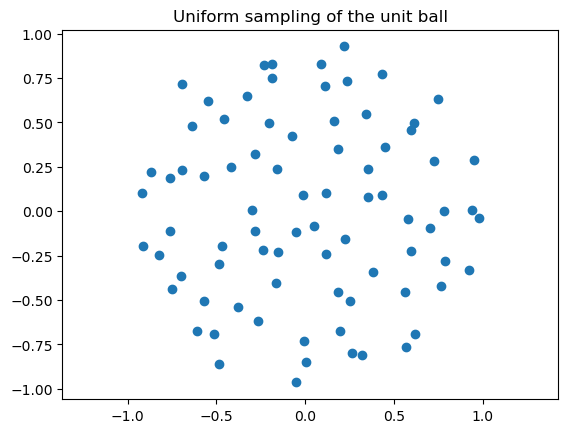

In [50]:
plt.title('Uniform sampling of the unit ball'); plt.axis('equal')
plt.scatter(*ball_samples(2,10));

In [51]:
def newton_extremize(f,x,niter,max_cond=1e10):
    """
    Runs niter steps of Newton's method for extremizing f. 
    (A.k.a, solve grad(f) = 0)
    """
    x_ad = ad.Dense2.identity(constant=x,shape_free=(len(x),))
    for i in range(niter):
        f_ad = f(x_ad)
#        print(np.linalg.eigvalsh(f_ad.coef2[0]))
        x_ad.value -= lp.solve_AV(f_ad.hessian(),f_ad.gradient())
    return x_ad.value,f_ad.value

In [52]:
def hooke_frame(c,proj,dens=8,niter=8):
    """
    Optimize the frame score, via a Newton method, with a large number of initial seeds.
    Return the best rotation and associated score.
    """
    def f(x): return frame_score(c,proj,rotation_from_ball(x))
    x = ball_samples({2:1,3:3}[c.vdim],dens) 
    x,f_x = newton_extremize(f,x,niter)
    argmin = np.nanargmin(f_x)
    return lp.transpose(rotation_from_ball(x[:,argmin])),f_x[argmin]

### 3.3 Two dimensions

In [53]:
np.random.seed(42) # Reproducibility

In [54]:
r,score = hooke_frame(norm2,proj_hooke2,dens=8)
print(f"Hooke tensor : \n{norm2.hooke}\nfound to be block diagonal in frame : \n{r},\nwith score : {score}.")
print(f"In this frame of reference : \n{norm2.rotate(r).hooke}")

Hooke tensor : 
[[154.88711806  26.86228904  35.4467799 ]
 [ 26.86228904  53.28830387  -0.69303566]
 [ 35.4467799   -0.69303566  24.56228904]]
found to be block diagonal in frame : 
[[-0.95533649 -0.29552021]
 [ 0.29552021 -0.95533649]],
with score : 6.247778369350414e-28.
In this frame of reference : 
[[ 1.78000000e+02  1.45000000e+01 -8.97253389e-15]
 [ 1.45000000e+01  5.49000000e+01  1.86710653e-15]
 [-1.24012868e-14  3.10068543e-15  1.22000000e+01]]


Likewise, a frame of reference with a negligible score residual is found for all our examples.

In [55]:
for name,norm in norms2[1:]:
    r,score = hooke_frame(norm,proj_hooke2,dens=8)
    print(f"Hooke tensor {name} found frame {r} with score {score}.")
    assert score<1e-8

Hooke tensor mica2 found frame [[-0.36235775 -0.93203909]
 [ 0.93203909 -0.36235775]] with score 4.827828739952593e-28.
Hooke tensor stishovite2 found frame [[ 0.47942554  0.87758256]
 [-0.87758256  0.47942554]] with score 4.038967834731581e-27.
Hooke tensor mudshale2 found frame [[ 0.87758256 -0.47942554]
 [ 0.47942554  0.87758256]] with score 2.1684043449710093e-18.


### 3.4 Three dimensions

**Note on performance.**
The numerical code presented below is too slow to be usable in practice, but could easily be (greatly) optimized. A lot of overhead is related with instance creation within the custom automatic differentiation library. A gpu accelerated code, orders of magnitude faster, is presented at the end of this document.

**Note on robustness.**
The `np.linalg.solve` fails in to the presence of singular matrices. We often encounter these, since we run a Newton method on a rather arbitrary (polynomial) function, without any guarantees, and from many seed points. An easy fix would be to abort the Newton method for all those seed points which raise such a singular matrix exception.

In [56]:
np.random.seed(44) # Reproducibility

In [57]:
hooke_frame(norm3,proj_orthorombic,dens=4)

(array([[-0.254809  , -0.96504472,  0.0613275 ],
        [-0.85672573,  0.25470969,  0.44849079],
        [-0.44843438,  0.06173864, -0.89168097]]),
 2.8985865812469996e-27)

In [58]:
for name,norm in norms3:
    r,score = hooke_frame(norm,proj_orthorombic,dens=5)
    print(f"Hooke tensor {name} found frame {r} with score {score}.")
    assert score<1e-8

Hooke tensor mica3 found frame [[ 0.96705012  0.20405886 -0.15223022]
 [ 0.19169447 -0.97712804 -0.09205447]
 [-0.16753295  0.05983959 -0.98404875]] with score 7.004377435266216e-28.


Hooke tensor stishovite3 found frame [[ 0.34276047  0.92847926  0.14297383]
 [-0.5152635   0.31306797 -0.79780447]
 [-0.78550544  0.19978664  0.5857188 ]] with score 2.853530775237862e-25.


## 4 GPU acceleration of the TTI projection

In order to apply the above projection to meaningful test cases for seimic applications, which involve millions of Hooke tensors, computation time must be sped up dramatically. 

The proposed GPU implementation is based on : 
- the treatment of each different hooke Tensor in a different thread, in an embarassingly parallel manner
- a specific optimization in dimension 3, taking advantage of the invariance of VTI metrics subject to rotations along the z-axis.

In [59]:
if ad.Base.cp is None: raise ad.DeliberateNotebookError("Cupy library not found")
from agd.Eikonal.HFM_CUDA.ProjectionTTI import ProjectionTTI

DeliberateNotebookError: Cupy library not found

In [9]:
def reload_packages():
    from Miscellaneous.rreload import rreload
    global ad,ProjectionTTI
    Hooke,ad,ProjectionTTI, = rreload([Hooke,ad,ProjectionTTI],rootdir="../..")

### 4.1 Taking advantage of VTI rotational invariance

**Three dimensions.**
Let us consider a material which does *not* have a TTI structure.

In [10]:
norm = Hooke.olivine[0]

And introduce the following rotations.

In [11]:
r0 = lp.rotation(0.8,(1,2,3)) # Some arbitrary rotation
def rx(θ): return lp.rotation(θ,(1,0,0)) # A rotation along the x-axis
def ry(θ): return lp.rotation(θ,(0,1,0)) # A rotation along the y-axis
def rz(θ): return lp.rotation(θ,(0,0,1)) # A rotation along the z-axis

Recall that the objective is to find a frame which minimizes the VTI projection error.
However, since the set of VTI tensors is invariant under the action of rotations along the z-axis, the projection error also is.

We also have some invariance by symmetry around the $x$ and $y$-axes. 

In [12]:
scores = [frame_score(norm,proj_hexagonal,r0 @ rx(θx) @ ry(θy) @ rz(θz))
          for θx in (0,np.pi) for θy in (0,np.pi) for θz in np.linspace(0,np.pi,10)]
assert np.allclose(scores,scores[0])

Any rotation matrix can be written as the composition
$$
    r(\theta_x,\theta_y,\theta_z) := r_x(\theta_x) r_y(\theta_y) r_z(\theta_z)
$$
of three rotations around the $x$, $y$ and $z$ axes.

Based on the above invariance property, if one wants to optimize the TTI projection error, then it is sufficient to optimize the parameter $\theta_x\in [0,\pi]$ and $\theta_y \in [0,\pi]$, and one can set $\theta_z=0$. 

Note that rotations along the $x$ and $y$ axes do not commute, but we have the identity
$$
    r_x(\pi) r_y(\theta_y) = r_y(-\theta_y) r_x(\pi).
$$

**Two dimensions.** There is a weaker invariance property, which that the set of VTI tensors is invariant under a rotation of $\pi/2$, exchanging the roles of the $x$ and $y$ axes.

### 4.2 Validation tests

Since the implementation is embarassingly parallel, the computation time does not increase much until the number of Hooke tensors exceeds the number of threads of the GPU (about 2560 on a GTX 1080).

In [13]:
np.random.seed(42)
norm = Hooke.olivine[0]
nrand = 2500
angle = np.random.uniform(0,np.pi,nrand)
axis = np.random.uniform(size=(3,nrand))
norms = norm.rotate_by(angle,axis)

In [14]:
%%time
score,hexa,rotation = ProjectionTTI(norms.hooke)
print(score[:10]) # Do not remove, otherwise false timing

[398.52292 398.52243 398.52237 398.5226  398.52246 398.52267 398.52206
 398.52283 398.52234 398.52252]
CPU times: total: 2.84 s
Wall time: 4.4 s


In this special case, we applied random rotations to a fixed norm. But then we inverse that process by finding the optimal frame of reference. As a result, the obtained TTI projection errors are all identical.
(Note that there is some amount of roundoff error, since the Hooke tensor coefficients are rather large, and the GPU uses single precision.)

Note that the original rotations, with the angles and axes defined above, *cannot* recovered, because of the $z$ rotational invariance.

In [15]:
np.max(np.abs(score-score[0]))

array(0.00195312, dtype=float32)

In [16]:
assert np.allclose(score,score[0],atol=0.2)

We recover the projection error scores defined in this notebook, up to a factor two.

In [17]:
score2 = 0.5*frame_score(norms,proj_hexagonal,rotation.get())
assert np.allclose(score2,score[0],atol=0.01)

In [19]:
tti_approx = Hooke.from_hexagonal(*hexa).rotate(rotation)
tti_approx = Hooke(tti_approx.hooke.get())
score3 = 0.5*np.sum( (tti_approx.to_Mandel()-norms.to_Mandel())**2,axis=(0,1) )
assert np.allclose(score3,score[0],atol=0.01)

We can build a TTI metric from the output of the algorithm.

In [20]:
TTI.from_hexagonal(*hexa).rotate(rotation);

By default, the ProjectionTTI implementation uses optimization over two angles. The quaternion approach was also implemented, for reproducibility, but it is slower and there should be no good reason to use it at this time. (The quaternion approach may be used in the future to compute projections onto a sets of Hooke tensors which are not $z$ rotationally invariant, such as orthorombic tensors.)

In [21]:
%%time
score_quat,hexa,rotation = ProjectionTTI(norms.hooke,quaternion=True)
print(score[:10]) # Do not remove, otherwise false timing

[398.52292 398.52243 398.52237 398.5226  398.52246 398.52267 398.52206
 398.52283 398.52234 398.52252]
CPU times: total: 3.05 s
Wall time: 3.06 s


By construction, the projection error is the same. However the rotations are expected to differ from the previous ones, again due to $z$ rotational invariance.

In [22]:
assert np.allclose(score_quat,score[0],atol=0.05)
tti_approx = Hooke.from_hexagonal(*hexa).rotate(rotation)
tti_approx = Hooke(tti_approx.hooke.get())
score3 = 0.5*np.sum( (tti_approx.to_Mandel()-norms.to_Mandel())**2,axis=(0,1) )
assert np.allclose(score3,score[0],atol=0.01)

Finally, we test the two dimensional implementation.
Since all classical two dimensional materials are TTI, we build a random positive definite Hooke tensor.

In [23]:
np.random.seed(42)
A = np.random.rand(3,3)-0.5
norm = Hooke(A.T @ A + 0.3*np.eye(3))
angles = 2*np.pi*np.random.rand(nrand)
norms = norm.rotate_by(angles)

In [24]:
%%time
score,hexa,rotation = ProjectionTTI(norms.hooke)
print(score[:10]) # Do not remove, otherwise false timing

[0.00021021 0.00021021 0.00021021 0.00021021 0.00021021 0.00021021
 0.00021021 0.00021021 0.00021021 0.00021021]
CPU times: total: 391 ms
Wall time: 391 ms


Again, since the same norm is subject to random rotations, the obtained projection errors are identical.

In [25]:
assert np.allclose(score,score[0],atol=1e-8)

In [26]:
score2 = 0.5*frame_score(norms,proj_hooke2,rotation.get())
assert np.allclose(score2,score[0],atol=1e-8)

In [27]:
tti_approx = Hooke.from_hexagonal(*hexa,vdim=2).rotate(rotation)
tti_approx = Hooke(tti_approx.hooke.get())
score3 = 0.5*np.sum( (tti_approx.to_Mandel()-norms.to_Mandel())**2,axis=(0,1) )
assert np.allclose(score3,score[0],atol=1e-8)

Again, one can build a TTI norm from the output of the algorithm.

In [28]:
TTI.from_hexagonal(*hexa,vdim=2).rotate(rotation);

Let us check visually the quality of the TTI approximation.
In this case it is almost perfect. Note that exact reconstruction is not possible in general, since a two dimensional Hooke tensor is defined by $6$ parameters, whereas the TTI approximation is defined by $5$ parameters (4 coefficients and an angle).

In [29]:
i0 = 10
c11,_,c13,c33,c44 = hexa
c11,c13,c33,c44 = [x[i0].get() for x in (c11,c13,c33,c44)]
tti0 = TTI.from_hexagonal(c11,None,c13,c33,c44,vdim=2).rotate(rotation[:,:,i0].get())
norm0 = norm.rotate_by(angles[i0])

#import cupy as cp
aX = np.linspace(-1.2,1.2)
X = np.meshgrid(aX,aX,indexing='ij')
plt.axis('equal')
plt.contour(*X,tti0.norm(X),levels=[1.01],colors='red') # Red : tti approximation
plt.contour(*X,norm0.norm(X),levels=[1],colors='blue'); # Blue : original hooke tensor

This time, in contrast with the three dimensional case, one can recover the rotation angles, up to a multiple of $\pi/2$ in view of the invariances.

In [32]:
score,hexa,θ = ProjectionTTI(norms.hooke,ret_rot=False)

In [33]:
diff = θ.get()+angles # Note the different sign conventions
diff = (diff - diff[0])/(np.pi/2) # convert to quarter turns

In [34]:
assert np.max(np.abs(np.round(diff) - diff)) < 1e-4